### Bert Base Cased ###

Train and evaluate on selfMA dataset balanced with Toxigen.

In [ ]:
!pip install -q transformers
!pip install -q torchinfo
!pip install -U -q datasets
!pip install -q evaluate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from datasets import load_from_disk, Dataset
import random
import pandas as pd
import numpy as np
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

train_df = pd.read_csv("/content/drive/MyDrive/W266_Fall2025_Neeha_Kotte/final_project/selfma_generated_combined_train_split.csv")
val_df = pd.read_csv("/content/drive/MyDrive/W266_Fall2025_Neeha_Kotte/final_project/selfma_generated_combined_validation_split.csv")
test_df = pd.read_csv("/content/drive/MyDrive/W266_Fall2025_Neeha_Kotte/final_project/selfma_generated_combined_test_split.csv")

def clean_dataframe(df):
    df = df[['text', 'label']]
    # Remove any missing values that could be throwing errors
    print(f"  Before dropping NaN: {len(df)} rows")
    df = df.dropna(subset=['text', 'label'])
    print(f"  After dropping NaN:  {len(df)} rows")

    df['text'] = df['text'].astype(str)
    df['label'] = df['label'].astype(int)

    df = df.reset_index(drop=True)

    return df

train_df = clean_dataframe(train_df)
val_df = clean_dataframe(val_df)
test_df = clean_dataframe(test_df)

balanced_selfMA_generated_train = Dataset.from_pandas(train_df)
balanced_selfMA_generated_val = Dataset.from_pandas(val_df)
balanced_selfMA_generated_test = Dataset.from_pandas(test_df)

random.seed(42)

max_sequence_length = 128

def preprocess_data(data, tokenizer):
    # Ensure text is a list of strings
    text = data['text']
    encoded = tokenizer.batch_encode_plus(
            text,
            max_length=max_sequence_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True
            # return_tensors="pt"
    )
    return encoded


metric = evaluate.load('accuracy')
f1  = evaluate.load("f1")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    return {
        **metric.compute(predictions=predictions, references=labels),
        "f1_macro": f1.compute(predictions=predictions, references=labels, average="macro")["f1"],
    }

  Before dropping NaN: 2080 rows
  After dropping NaN:  2079 rows
  Before dropping NaN: 260 rows
  After dropping NaN:  260 rows
  Before dropping NaN: 260 rows
  After dropping NaN:  260 rows


In [ ]:
def fine_tune_classification_model(classification_model,
                                   tokenizer,
                                   train_data,
                                   dev_data,
                                   batch_size = 16,
                                   num_epochs = 3,
                                   learning_rate=2e-5):
    """
    Preprocess the data using the given tokenizer (we've give you the code for that part).
    Create the training arguments and trainer for the given model and data (write your code for that).
    Then train it.
    """

    preprocessed_train_data = train_data.map(preprocess_data, batched=True, fn_kwargs={'tokenizer': tokenizer})
    preprocessed_dev_data = dev_data.map(preprocess_data, batched=True, fn_kwargs={'tokenizer': tokenizer})

    # Referencing lesson 4 notebook & assignment 2 as an example:
    training_args = TrainingArguments(
      output_dir="bert_selfMA_generated_balanced",
      per_device_train_batch_size=batch_size,
      per_device_eval_batch_size=batch_size,
      num_train_epochs=num_epochs,
      learning_rate=learning_rate,
      eval_strategy="epoch",
      save_strategy="epoch",
      report_to='none',
      load_best_model_at_end = True,
      metric_for_best_model = "f1_macro",
      seed = 42
    )

    trainer = Trainer(
      model=classification_model,
      args=training_args,
      train_dataset=preprocessed_train_data,
      eval_dataset=preprocessed_dev_data,
      compute_metrics=compute_metrics
    )

    trainer.train()

    return trainer

In [ ]:
model_checkpoint_name = "bert-base-cased"
bert_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
bert_classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name, num_labels = 2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
bert_base_cased_trainer = fine_tune_classification_model(bert_classification_model, bert_tokenizer, balanced_selfMA_generated_train, balanced_selfMA_generated_val)

Map:   0%|          | 0/2079 [00:00<?, ? examples/s]

Map:   0%|          | 0/260 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.232473,0.926923,0.926896
2,No log,0.238051,0.907692,0.907341
3,No log,0.241401,0.919231,0.919201


### Evaluate on selfMA generated: ###

In [ ]:
preprocessed_test_data = balanced_selfMA_generated_test.map(preprocess_data, batched=True, fn_kwargs={'tokenizer': bert_tokenizer})
predictions = bert_base_cased_trainer.predict(preprocessed_test_data)
preprocessed_test_pred_bert_base = np.argmax(predictions.predictions, axis=1)
y_true_bert_base = balanced_selfMA_generated_test['label']
from sklearn.metrics import accuracy_score, classification_report

test_accuracy_bert_base = accuracy_score(y_true_bert_base, preprocessed_test_pred_bert_base)
print(f"\nTest Accuracy: {test_accuracy_bert_base:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_bert_base, preprocessed_test_pred_bert_base, target_names=['0: Non-aggressive/normal text', '1: Microaggression']))

Map:   0%|          | 0/260 [00:00<?, ? examples/s]


Test Accuracy: 0.8962

Classification Report:
                               precision    recall  f1-score   support

0: Non-aggressive/normal text       0.91      0.88      0.89       130
           1: Microaggression       0.88      0.92      0.90       130

                     accuracy                           0.90       260
                    macro avg       0.90      0.90      0.90       260
                 weighted avg       0.90      0.90      0.90       260



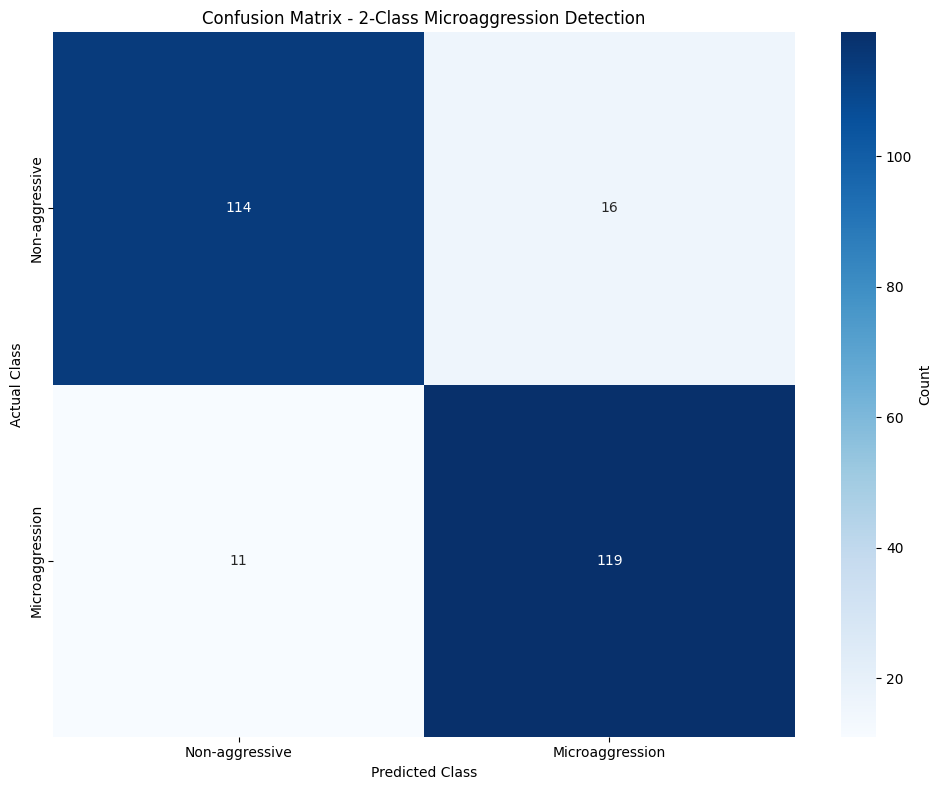

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true_bert_base, preprocessed_test_pred_bert_base)
class_names = ['Non-aggressive', 'Microaggression']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix - 2-Class Microaggression Detection')
plt.tight_layout()
plt.show()

### Evaluate on Workplace MA: ###

In [ ]:
micro_agg_url = "https://huggingface.co/spaces/khanak27/microaggressionsdetector/resolve/main/micro_agg.csv"
# Try different encodings to handle Unicode issues
encodings_to_try = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1', 'utf-8-sig']

df_micro = None
for encoding in encodings_to_try:
    try:
        print(f"Trying encoding: {encoding}")
        df_micro = pd.read_csv(micro_agg_url, encoding=encoding)
        print(f"✅ Successfully loaded with {encoding} encoding")
        break
    except UnicodeDecodeError as e:
        print(f"❌ Failed with {encoding}: {str(e)[:100]}...")
        continue
    except Exception as e:
        print(f"❌ Other error with {encoding}: {str(e)[:100]}...")
        continue

if df_micro is None:
    print("❌ Failed to load dataset with any encoding. Trying with error handling...")
    try:
        df_micro = pd.read_csv(micro_agg_url, encoding='utf-8', encoding_errors='replace')
        print("✅ Loaded with UTF-8 and error replacement")
    except Exception as e:
        print(f"❌ Final attempt failed: {e}")
        raise

df_micro['text'] = df_micro['speech']
workplace_microaggressions_dataset = Dataset.from_dict({
    'text': df_micro['text'].fillna('').tolist(),
    'label': df_micro['label'].tolist()
})

Trying encoding: utf-8
❌ Failed with utf-8: 'utf-8' codec can't decode byte 0xe2 in position 17: invalid continuation byte...
Trying encoding: latin-1
✅ Successfully loaded with latin-1 encoding


In [ ]:
preprocessed_workplaceMA_test_data = workplace_microaggressions_dataset.map(preprocess_data, batched=True, fn_kwargs={'tokenizer': bert_tokenizer})
predictions = bert_base_cased_trainer.predict(preprocessed_workplaceMA_test_data)
preprocessed_workplaceMA_pred_bert_base = np.argmax(predictions.predictions, axis=1)
y_true_bert_base_workplaceMA = workplace_microaggressions_dataset['label']
from sklearn.metrics import accuracy_score, classification_report

test_accuracy_workplaceMA_bert_base = accuracy_score(y_true_bert_base_workplaceMA, preprocessed_workplaceMA_pred_bert_base)
print(f"\nTest Accuracy WorkplaceMA: {test_accuracy_workplaceMA_bert_base:.4f}")
print("\nClassification Report WorkplaceMA:")
print(classification_report(y_true_bert_base_workplaceMA, preprocessed_workplaceMA_pred_bert_base, target_names=['0: Non-aggressive/normal text', '1: Microaggression']))

Map:   0%|          | 0/171 [00:00<?, ? examples/s]


Test Accuracy WorkplaceMA: 0.8070

Classification Report WorkplaceMA:
                               precision    recall  f1-score   support

0: Non-aggressive/normal text       0.75      0.93      0.83        87
           1: Microaggression       0.90      0.68      0.78        84

                     accuracy                           0.81       171
                    macro avg       0.83      0.80      0.80       171
                 weighted avg       0.83      0.81      0.80       171



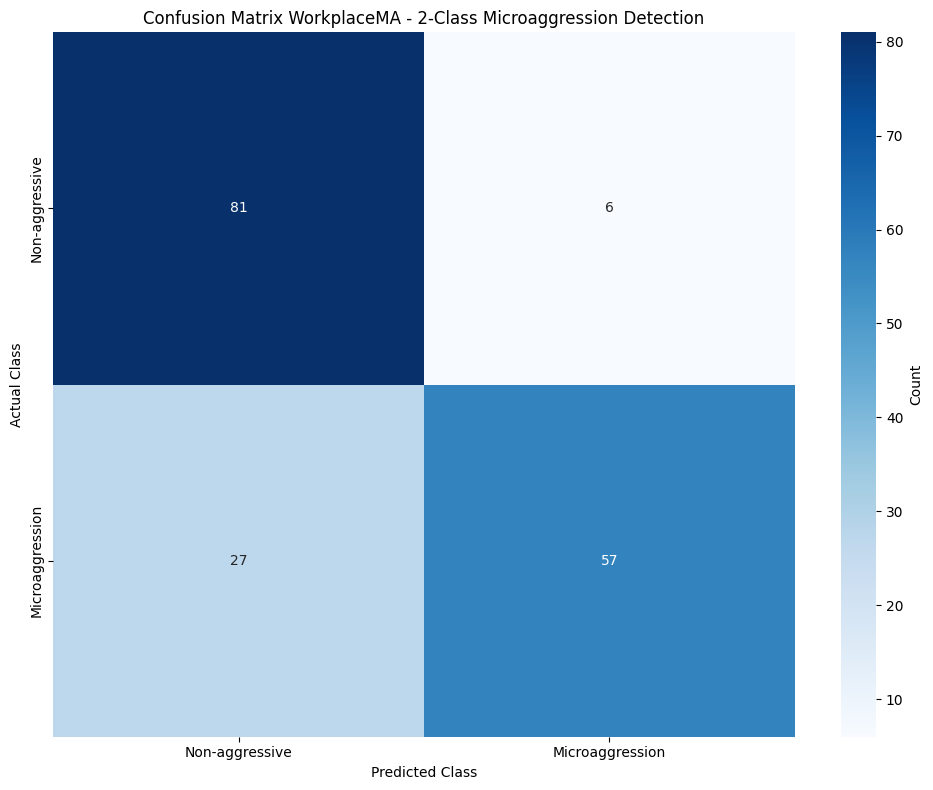

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true_bert_base_workplaceMA, preprocessed_workplaceMA_pred_bert_base)
class_names = ['Non-aggressive', 'Microaggression']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix WorkplaceMA - 2-Class Microaggression Detection')
plt.tight_layout()
plt.show()

### Hate Bert ###

In [ ]:
model_checkpoint_name = "GroNLP/hateBERT"
hatebert_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
hatebert_classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name, num_labels = 2)

tokenizer_config.json:   0%|          | 0.00/151 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
hatebert_trainer = fine_tune_classification_model(hatebert_classification_model, hatebert_tokenizer, balanced_selfMA_generated_train, balanced_selfMA_generated_val)

Map:   0%|          | 0/2079 [00:00<?, ? examples/s]

Map:   0%|          | 0/260 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.232304,0.911538,0.911537
2,No log,0.260914,0.903846,0.903731
3,No log,0.265438,0.903846,0.903833


In [ ]:
preprocessed_test_data = balanced_selfMA_generated_test.map(preprocess_data, batched=True, fn_kwargs={'tokenizer': hatebert_tokenizer})
predictions = hatebert_trainer.predict(preprocessed_test_data)
preprocessed_test_pred_hatebert = np.argmax(predictions.predictions, axis=1)
y_true_hatebert = balanced_selfMA_generated_test['label']
from sklearn.metrics import accuracy_score, classification_report

test_accuracy_hatebert = accuracy_score(y_true_hatebert, preprocessed_test_pred_hatebert)
print(f"\nTest Accuracy: {test_accuracy_hatebert:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_hatebert, preprocessed_test_pred_hatebert, target_names=['0: Non-aggressive/normal text', '1: Microaggression']))

Map:   0%|          | 0/260 [00:00<?, ? examples/s]


Test Accuracy: 0.8769

Classification Report:
                               precision    recall  f1-score   support

0: Non-aggressive/normal text       0.90      0.85      0.87       130
           1: Microaggression       0.86      0.91      0.88       130

                     accuracy                           0.88       260
                    macro avg       0.88      0.88      0.88       260
                 weighted avg       0.88      0.88      0.88       260



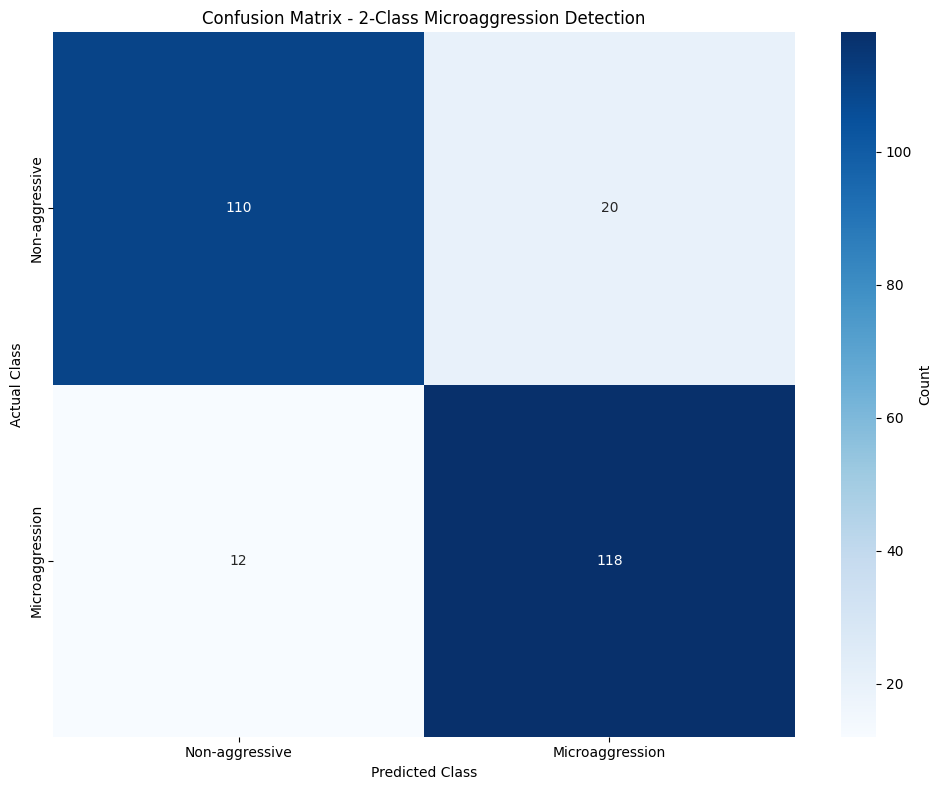

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true_hatebert, preprocessed_test_pred_hatebert)
class_names = ['Non-aggressive', 'Microaggression']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix - 2-Class Microaggression Detection')
plt.tight_layout()
plt.show()

### Evaluate on Workplace MA: ###

In [ ]:
preprocessed_workplaceMA_test_data = workplace_microaggressions_dataset.map(preprocess_data, batched=True, fn_kwargs={'tokenizer': hatebert_tokenizer})
predictions = hatebert_trainer.predict(preprocessed_workplaceMA_test_data)
preprocessed_workplaceMA_pred_hate_bert = np.argmax(predictions.predictions, axis=1)
y_true_hatebert_workplaceMA = workplace_microaggressions_dataset['label']
from sklearn.metrics import accuracy_score, classification_report

test_accuracy_workplaceMA_hate_bert = accuracy_score(y_true_hatebert_workplaceMA, preprocessed_workplaceMA_pred_hate_bert)
print(f"\nTest Accuracy WorkplaceMA: {test_accuracy_workplaceMA_hate_bert:.4f}")
print("\nClassification Report WorkplaceMA:")
print(classification_report(y_true_hatebert_workplaceMA, preprocessed_workplaceMA_pred_hate_bert, target_names=['0: Non-aggressive/normal text', '1: Microaggression']))

Map:   0%|          | 0/171 [00:00<?, ? examples/s]


Test Accuracy WorkplaceMA: 0.8012

Classification Report WorkplaceMA:
                               precision    recall  f1-score   support

0: Non-aggressive/normal text       0.73      0.95      0.83        87
           1: Microaggression       0.93      0.64      0.76        84

                     accuracy                           0.80       171
                    macro avg       0.83      0.80      0.80       171
                 weighted avg       0.83      0.80      0.80       171



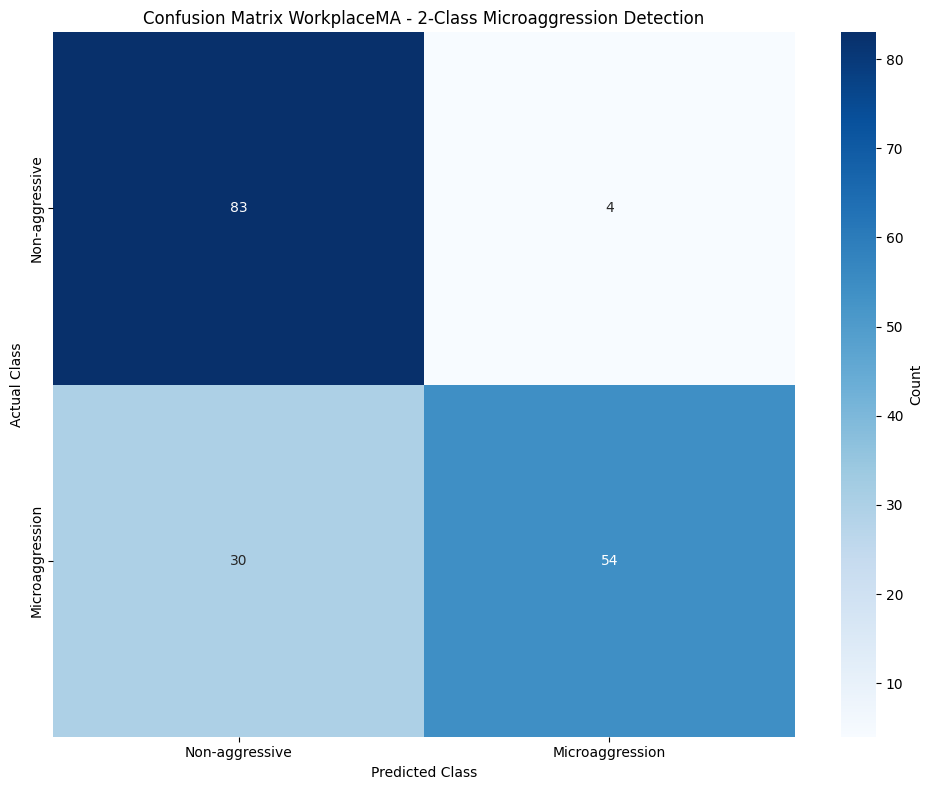

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true_hatebert_workplaceMA, preprocessed_workplaceMA_pred_hate_bert)
class_names = ['Non-aggressive', 'Microaggression']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix WorkplaceMA - 2-Class Microaggression Detection')
plt.tight_layout()
plt.show()

### RoBERTa Base ###

In [ ]:
model_checkpoint_name = "roberta-base"
roberta_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
roberta_classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name, num_labels = 2)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
roberta_trainer = fine_tune_classification_model(roberta_classification_model, roberta_tokenizer, balanced_selfMA_generated_train, balanced_selfMA_generated_val)

Map:   0%|          | 0/2079 [00:00<?, ? examples/s]

Map:   0%|          | 0/260 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.301194,0.896154,0.895894
2,No log,0.337771,0.900000,0.899620
3,No log,0.353408,0.926923,0.926896


In [ ]:
preprocessed_test_data = balanced_selfMA_generated_test.map(preprocess_data, batched=True, fn_kwargs={'tokenizer': roberta_tokenizer})
predictions = roberta_trainer.predict(preprocessed_test_data)
preprocessed_test_pred_roberta = np.argmax(predictions.predictions, axis=1)
y_true_roberta = balanced_selfMA_generated_test['label']
from sklearn.metrics import accuracy_score, classification_report

test_accuracy_roberta = accuracy_score(y_true_roberta, preprocessed_test_pred_roberta)
print(f"\nTest Accuracy: {test_accuracy_roberta:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_roberta, preprocessed_test_pred_roberta, target_names=['0: Non-aggressive/normal text', '1: Microaggression']))

Map:   0%|          | 0/260 [00:00<?, ? examples/s]


Test Accuracy: 0.9154

Classification Report:
                               precision    recall  f1-score   support

0: Non-aggressive/normal text       0.90      0.93      0.92       130
           1: Microaggression       0.93      0.90      0.91       130

                     accuracy                           0.92       260
                    macro avg       0.92      0.92      0.92       260
                 weighted avg       0.92      0.92      0.92       260



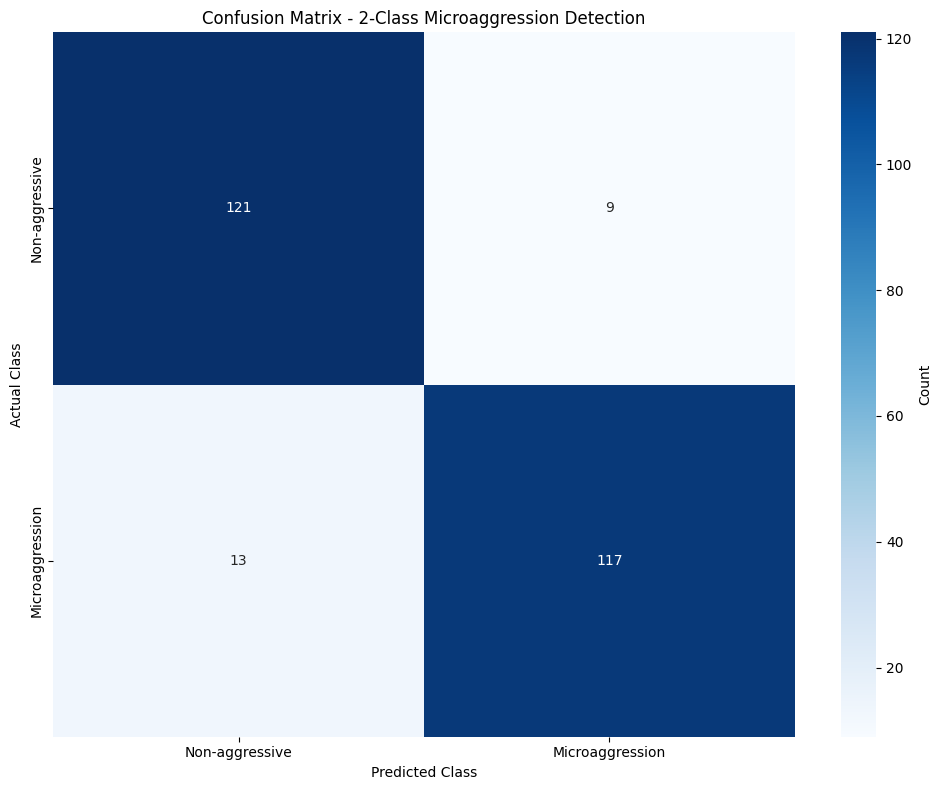

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true_roberta, preprocessed_test_pred_roberta)
class_names = ['Non-aggressive', 'Microaggression']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix - 2-Class Microaggression Detection')
plt.tight_layout()
plt.show()

### Evaluate on Workplace MA: ###

In [ ]:
preprocessed_workplaceMA_test_data = workplace_microaggressions_dataset.map(preprocess_data, batched=True, fn_kwargs={'tokenizer': roberta_tokenizer})
predictions = roberta_trainer.predict(preprocessed_workplaceMA_test_data)
preprocessed_workplaceMA_pred_roberta = np.argmax(predictions.predictions, axis=1)
y_true_roberta_workplaceMA = workplace_microaggressions_dataset['label']
from sklearn.metrics import accuracy_score, classification_report

test_accuracy_workplaceMA_roberta = accuracy_score(y_true_roberta_workplaceMA, preprocessed_workplaceMA_pred_roberta)
print(f"\nTest Accuracy WorkplaceMA: {test_accuracy_workplaceMA_roberta:.4f}")
print("\nClassification Report WorkplaceMA:")
print(classification_report(y_true_roberta_workplaceMA, preprocessed_workplaceMA_pred_roberta, target_names=['0: Non-aggressive/normal text', '1: Microaggression']))

Map:   0%|          | 0/171 [00:00<?, ? examples/s]


Test Accuracy WorkplaceMA: 0.7661

Classification Report WorkplaceMA:
                               precision    recall  f1-score   support

0: Non-aggressive/normal text       0.69      1.00      0.81        87
           1: Microaggression       1.00      0.52      0.69        84

                     accuracy                           0.77       171
                    macro avg       0.84      0.76      0.75       171
                 weighted avg       0.84      0.77      0.75       171



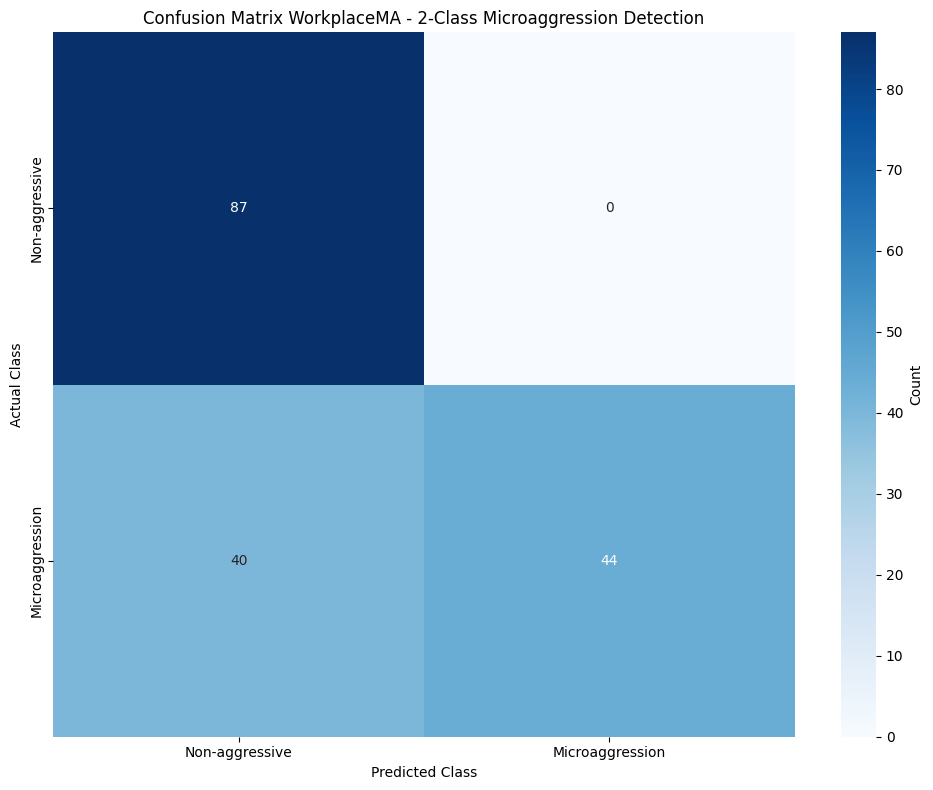

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true_roberta_workplaceMA, preprocessed_workplaceMA_pred_roberta)
class_names = ['Non-aggressive', 'Microaggression']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix WorkplaceMA - 2-Class Microaggression Detection')
plt.tight_layout()
plt.show()

### DeBERTa Base ###

In [ ]:
model_checkpoint_name = "microsoft/deberta-v3-base"
deberta_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
deberta_classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name, num_labels = 2)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
deberta_trainer = fine_tune_classification_model(deberta_classification_model, deberta_tokenizer, balanced_selfMA_generated_train, balanced_selfMA_generated_val)

Map:   0%|          | 0/2079 [00:00<?, ? examples/s]

Map:   0%|          | 0/260 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.232368,0.923077,0.923036
2,No log,0.297454,0.911538,0.911432
3,No log,0.292814,0.923077,0.923072


In [ ]:
preprocessed_test_data = balanced_selfMA_generated_test.map(preprocess_data, batched=True, fn_kwargs={'tokenizer': deberta_tokenizer})
predictions = deberta_trainer.predict(preprocessed_test_data)
preprocessed_test_pred_deberta = np.argmax(predictions.predictions, axis=1)
y_true_deberta = balanced_selfMA_generated_test['label']
from sklearn.metrics import accuracy_score, classification_report

test_accuracy_deberta = accuracy_score(y_true_deberta, preprocessed_test_pred_deberta)
print(f"\nTest Accuracy: {test_accuracy_deberta:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_deberta, preprocessed_test_pred_deberta, target_names=['0: Non-aggressive/normal text', '1: Microaggression']))

Map:   0%|          | 0/260 [00:00<?, ? examples/s]


Test Accuracy: 0.9269

Classification Report:
                               precision    recall  f1-score   support

0: Non-aggressive/normal text       0.94      0.92      0.93       130
           1: Microaggression       0.92      0.94      0.93       130

                     accuracy                           0.93       260
                    macro avg       0.93      0.93      0.93       260
                 weighted avg       0.93      0.93      0.93       260



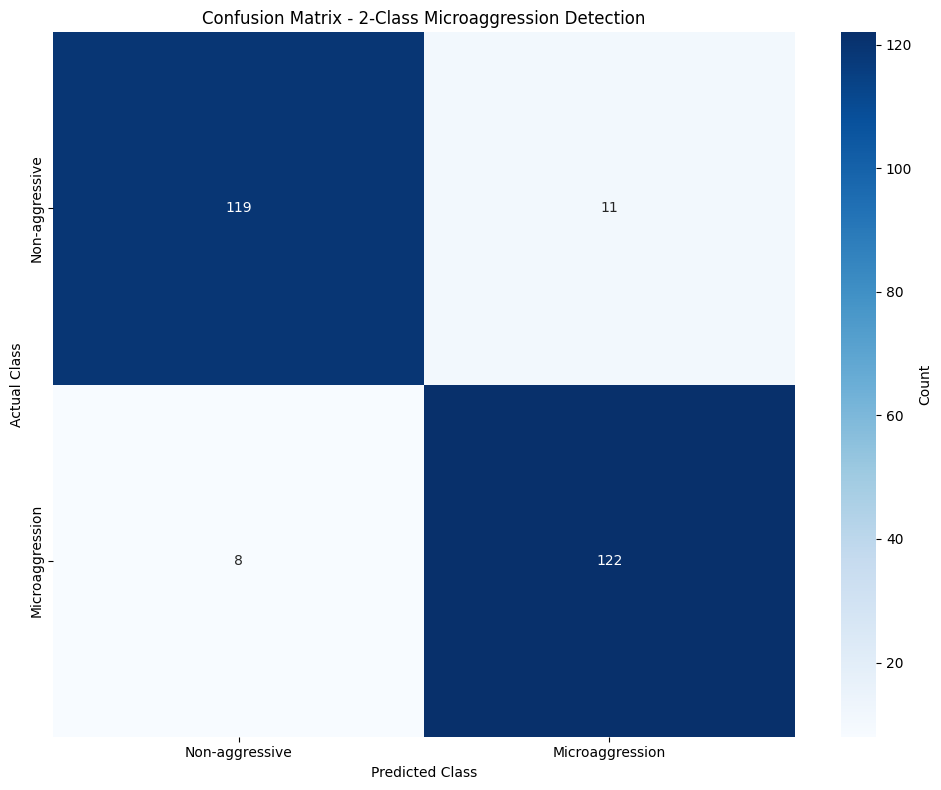

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true_deberta, preprocessed_test_pred_deberta)
class_names = ['Non-aggressive', 'Microaggression']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix - 2-Class Microaggression Detection')
plt.tight_layout()
plt.show()

### Evaluate on Workplace MA: ###

In [ ]:
preprocessed_workplaceMA_test_data = workplace_microaggressions_dataset.map(preprocess_data, batched=True, fn_kwargs={'tokenizer': deberta_tokenizer})
predictions = deberta_trainer.predict(preprocessed_workplaceMA_test_data)
preprocessed_workplaceMA_pred_deberta = np.argmax(predictions.predictions, axis=1)
y_true_deberta_workplaceMA = workplace_microaggressions_dataset['label']
from sklearn.metrics import accuracy_score, classification_report

test_accuracy_workplaceMA_deberta = accuracy_score(y_true_deberta_workplaceMA, preprocessed_workplaceMA_pred_deberta)
print(f"\nTest Accuracy WorkplaceMA: {test_accuracy_workplaceMA_deberta:.4f}")
print("\nClassification Report WorkplaceMA:")
print(classification_report(y_true_deberta_workplaceMA, preprocessed_workplaceMA_pred_deberta, target_names=['0: Non-aggressive/normal text', '1: Microaggression']))

Map:   0%|          | 0/171 [00:00<?, ? examples/s]


Test Accuracy WorkplaceMA: 0.8187

Classification Report WorkplaceMA:
                               precision    recall  f1-score   support

0: Non-aggressive/normal text       0.74      1.00      0.85        87
           1: Microaggression       1.00      0.63      0.77        84

                     accuracy                           0.82       171
                    macro avg       0.87      0.82      0.81       171
                 weighted avg       0.87      0.82      0.81       171



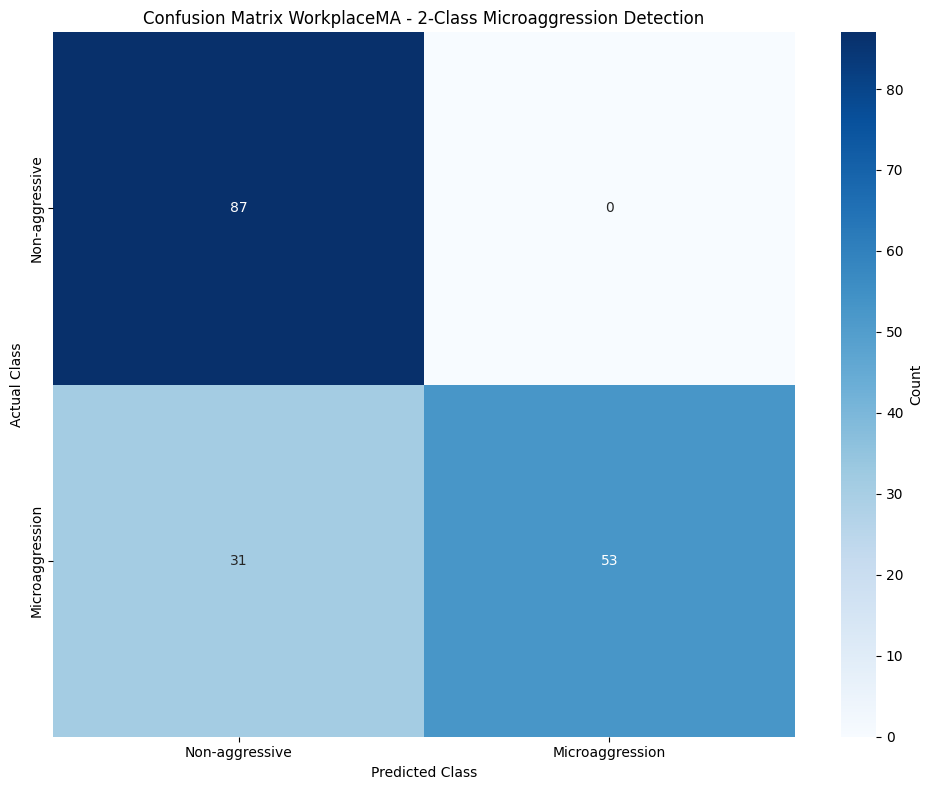

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true_deberta_workplaceMA, preprocessed_workplaceMA_pred_deberta)
class_names = ['Non-aggressive', 'Microaggression']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix WorkplaceMA - 2-Class Microaggression Detection')
plt.tight_layout()
plt.show()